In [11]:
from gimpformats.gimpXcfDocument import GimpDocument
import cv2
import numpy as np

In [12]:
def imageListFromXcf(fileName):
    """ Give a the name of an xcf file, read it using GimpDocument
        extract and return a list of images along with a list of layer names, return it as two lists
    """

    """List data on groups followed by the direct children of a gimp xcf document
    """
    project = GimpDocument(fileName)

    layers = project.layers
    index = 0
    #print("## Group info...")
    #while index < len(layers):
    #    layerOrGroup = layers[index]
    #    if layerOrGroup.isGroup:
    #        index += 1
    #        while layers[index].itemPath is not None:
    #            #print("Group \"" + layerOrGroup.name + "\" contains Layer \"" + layers[index].name + "\"")
    #            layers.pop(index)
    #    else:
    #        index += 1

    #print("## Document direct children...")
    #images = []
    #for layerOrGroup in layers:
    #    print("\"" + layerOrGroup.name + "\" is a " + ("Group" if layerOrGroup.isGroup else "Layer"))
    #    images.append(layerOrGroup.image)
        #layerOrGroup.image.save(layerOrGroup.name+"amb.png")
    return zip(*[(l.name,l.image) for l in layers if not l.isGroup ][:-1])# CAREFUL!
    # Taking out the last one as it contains the full image!!!!!
   

    
def imageToPoints(image):
    
    # binarize image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray[gray > 0] = 255  

    #compute connected components
    numLabels, labelImage,stats, centroids = cv2.connectedComponentsWithStats(gray)
    
    #print("returning "+str(centroids[1:]))
    #plt.imshow(image)
   
    return centroids[1:] #eliminate background centroid

def makeDict(names,points):
    return { names[i]: points[i] for i in range(len(names)) }
    

def readAnnotationFile(fileName):
    """ Give a the name of an xcf file, read it using GimpDocument
        First extract a list of images, 
        Then extract from each image the landmark points
        return the name of each layer along with the list of points
    """

    
    names,images = imageListFromXcf(fileName)
    points = [imageToPoints(np.array(x)) for x in images]
    
    return names,images,points

In [13]:
# POINT METRICS
from scipy.spatial.distance import directed_hausdorff
import numpy as np
import persim

def hausdorff(set1,set2):
    """ Given two sets of points, compute their hausdorff distance

    """    
    print("Computing hausdorf distance of set "+str(set1)+" and "+str(set2))
    return directed_hausdorff(set1,set2)
        
"""
The following function can be made much more efficient with Kd-trees (but probably no need given our data sizes)
"""
def avEUC(set1,set2):
    """
    Average euclidean distance from a point in one set to the closest point in the other set
    """
    def closestDist(p, set2):
        """
            Smaller euclidean Distance from point to set
        """
        minDist = np.linalg.norm(p - set2[0])
        for q in set2[1:]:
            newDist = np.linalg.norm(p - q)
            if newDist < minDist:
                minDist = newDist
        return minDist
    # iterate over all the set
    sum = 0
    for p in set1:
        sum+=closestDist(p,set2)
    return sum/len(set1)
    
def bottleneck(set1,set2):
    """
        Bottleneck Distance between point sets
    """
    return persim.bottleneck(set1, set2, matching=True)[0]

    

In [14]:
# IMAGE METRICS
from skimage.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
#from skimage.metrics import normalized_mutual_information as nim

def MSE(im1,im2):
    """
    Mean Squared Error image metric
    """
    return  mean_squared_error(img1, im2)

def SSIM(im1,im2):
    """
    Structural Similarity Index image metric
    """
    return ssim(im1, im2,data_range=max(im1.max(),im2.max()) - min(im1.min(),im2.min()))

def NMI(im1,im2):
    """
    Normalized mutual informacion image metric
    """
    return nmi(im1,im2)

('calota', 'talems', 'cerebel', 'cavum', 'silvio', 'astes anteriors', 'linia mitja')
4
4
8
4
3
2
2


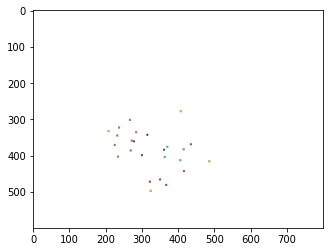

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

names,images,points = readAnnotationFile("data/3.xcf")

print(names)
for x in points:
    print(len(x))

plt.imshow(images[0])
plt.imshow(images[1])
plt.imshow(images[2])
plt.imshow(images[3])
plt.imshow(images[4])
plt.imshow(images[5])

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline


names,_,points1 = readAnnotationFile("data/1.xcf")
dict1 = makeDict(names,points1)

names2,_,points2 = readAnnotationFile("data/Clandmarks.xcf")
dict2 = makeDict(names2,points2)

names3,_,points3 = readAnnotationFile("data/3.xcf")
dict3 = makeDict(names3,points3)

names4,_,points4 = readAnnotationFile("data/4.xcf")
dict4 = makeDict(names4,points4)

print("not all the annotations contain the same layers")
print(names)
print(names2)
print(names3)
print(names4)

print("lists of layers with their assigned points")
print(dict1)
print(dict2)
print(dict3)
print(dict4)

not all the annotations contain the same layers
('Córtex', 'calota', 'talems', 'cerebel', 'cavum', 'silvio', 'astes anteriors', 'linia mitja')
('linia mitja', 'astes anteriors', 'silvio', 'cerebel #1', 'c3', 'cerebel', 'talems', 'calota', 'Córtex')
('calota', 'talems', 'cerebel', 'cavum', 'silvio', 'astes anteriors', 'linia mitja')
('calota', 'talems', 'cerebel', 'cavum', 'silvio', 'astes anteriors', 'linia mitja')
lists of layers with their assigned points
{'Córtex': array([[273., 466.],
       [303., 476.]]), 'calota': array([[342., 186.],
       [569., 324.],
       [192., 357.],
       [368., 498.]]), 'talems': array([[428., 296.],
       [462., 331.],
       [356., 341.],
       [432., 371.]]), 'cerebel': array([[507., 258.],
       [543., 295.],
       [468., 299.],
       [533., 327.],
       [470., 333.],
       [544., 358.],
       [475., 363.],
       [520., 397.]]), 'cavum': array([[297., 325.],
       [345., 327.],
       [302., 358.],
       [348., 358.]]), 'silvio': array

In [20]:
# now, take the points that we have computed and use them to compute some distances
aDict = dict1
anotherDict = dict2

for lay in aDict.keys():
    if lay in dict2:
        # retrieve points 
        set1 = aDict[lay]
        set2 = anotherDict[lay]
        dist = bottleneck(set1,set2)
        #dist = hausdorff(set1,set2)
        #dist = avEUC(set1,set2)

        print("Distance computed for layer "+str(lay)+" : "+str(dist))

Distance computed for layer Córtex : 173.36288938750596
Distance computed for layer calota : 134.01402922048612
Distance computed for layer talems : 175.06179810230913
Distance computed for layer cerebel : 169.81847151506264
Distance computed for layer silvio : 174.60029164848615
Distance computed for layer astes anteriors : 144.65585554138164
Distance computed for layer linia mitja : 164.15499540906967
